In [1]:
from jax_circuits import *
# from exact_decompositions import *
from qiskit import transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from cp_utils import *
from scipy.stats import unitary_group

To do

1. Local minima plots in an accurate way:
    1. For each ansatz several random unitaries and several self-unitaries. 
    1. Separately stats for different realizations of Toffoli 3 and Toffoli 4 gates.

# Local minimums

## Empirical success ratio: definition and example

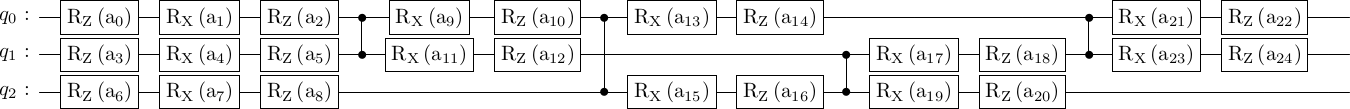

In [24]:
anz = Ansatz(3, 'cz', fill_layers(connected_layer(3), 4))
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)

anz.circuit().draw(output='latex')

In [25]:
print(target_circuit.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Z}\,(\mathrm{6.246})} & \gate{\mathrm{R_X}\,(\mathrm{0.5124})} & \gate{\mathrm{R_Z}\,(\mathrm{1.219})} & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{1.903})} & \gate{\mathrm{R_Z}\,(\mathrm{5.638})} & \ctrl{2} & \gate{\mathrm{R_X}\,(\mathrm{2.711})} & \gate{\mathrm{R_Z}\,(\mathrm{5.384})} & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{1.105})} & \gate{\mathrm{R_Z}\,(\mathrm{1.16})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_Z}\,(\mathrm{4.646})} & \gate{\mathrm{R_X}\,(\mathrm{2.216})} & \gate{\mathrm{R_Z}\,(\mathrm{1.714})} & \control\qw & \gate{\mathrm{R_X}\,(\mathrm{2.833})} & \gate{\mathrm{R_Z}\,(\mathrm{0.6454})} & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{2.812})} & \gate{\mathrm{R_Z}\,(\mathrm

In [15]:
results = anz.learn(target_unitary, num_repeats=100)

In [19]:
success_record = [jnp.min(r['loss'])<1e-4 for r in results]
sum(success_record)/len(success_record)

DeviceArray(0.46, dtype=float32)

In [ ]:
target_circuit

In [78]:
results_self = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        

In [79]:
def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

In [106]:
anz = Ansatz(2, 'cz', fill_layers(sequ_layer(2),2))
anz.learn(jnp.identity(4), keep_history=False)

{'params': DeviceArray([[ 5.754299  ,  1.3584471 ,  1.6861063 ,  3.7769492 ,
                2.748102  ,  5.365713  ,  3.5388346 ,  0.86656886,
                2.001221  ,  4.5974364 ,  5.9759526 ,  2.0757704 ,
                1.5540582 ,  0.2268112 ],
              [ 6.5517073 ,  2.0547414 ,  1.3540331 ,  3.3458786 ,
                2.6183314 ,  5.0481944 ,  3.141516  ,  1.3540308 ,
                3.1417074 ,  5.0481663 ,  5.196244  ,  2.873174  ,
               -0.5232145 , -0.20425496]], dtype=float32),
 'loss': DeviceArray([ 9.6465313e-01, -4.7683716e-07], dtype=float32),
 'reg': DeviceArray([0, 0], dtype=int32),
 'regloss': DeviceArray([ 9.6465313e-01, -4.7683716e-07], dtype=float32)}

Text(0.5, 1.0, 'Local minimums in 3q circuits')

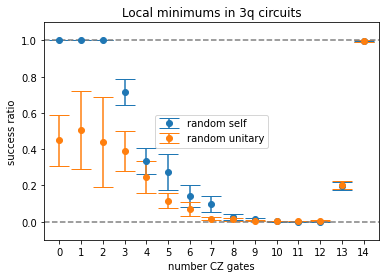

In [102]:
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)
plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random self')
plt.errorbar(range(len(mean_list_unitary)), mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend()

plt.ylim([-0.1, 1.1])
# plt.yscale('log')
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=1, color='grey', linestyle='--')
plt.xticks(range(len(mean_list_unitary)))
plt.ylabel('success ratio')
plt.xlabel('number CZ gates')
plt.title('Local minimums in 3q circuits')